# Classificateur de Bayes et maximum de vraisemblance d'une loi gaussienne multivariée

## Preface/Préface

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, SelectMultiple, fixed, Checkbox, IntRangeSlider, IntSlider, FloatSlider
import ipywidgets as widgets
matplotlib.rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight')

Commencez, si nécessaire, par faire une révision des notes de cours portant sur le [classificateur de Bayes](https://studium.umontreal.ca/pluginfile.php/4027948/mod_resource/content/4/7_bayes_classifier-en.pdf) et sur le principe du [maximum de vraisemblance](https://studium.umontreal.ca/pluginfile.php/4003963/mod_resource/content/4/5_gaussian_distribution_en.pdf).


## Description détaillée

Aujourd'hui, nous allons construire un **classîficateur de Bayes multi-classes**. Ceci veut dire qu'à la place de modéliser  $ p (\mbox{classe} \ | \ \mbox{exemple}) $ (ou $ p (y \ | \ x) $), nous allons plutôt utiliser la formule de Bayes suivante:

$$ p (\mbox{classe} \ | \ \mbox{exemple}) = \frac{p (\mbox{exemple} \ | \ \mbox{classe}) p (\mbox {classe})} {\sum_{c'= 1}^{m} p_\mbox{c'}(x) P_\mbox{c'}} $$

et allons modéliser différents termes. En fait, nous avons uniquement besoin de modéliser le numérateur puisque le dénominateur  est une constante de normalisation. De plus, $ P_\mbox{c '} = n_c / n $.

Le terme $ p (\mbox{classe}) $ représente la probabilité à priori d'une classe, c'est-à-dire notre hypothèse à priori - avant avoir vu un certain exemple - de la probabilité qu'un exemple quelconque appartienne à cette classe. Nous allons représenter cette hypothèse par sa fréquence dans notre jeu d'entraînement: $ \frac{n_c}{n} $, où $ n_c $ est le nombre d'exemples appartement à cette classe et $ n $ est le nombre d'exemples dans notre jeu d'entraînement.

Nous allons utiliser des **gaussiennes multivariées** afin de modéliser les différentes probabilités $ p (\mbox{exemple} \ | \ \mbox{classe}) $. En d'autres mots, nous assumons que pour **chaque classe** $c$, la *vraie* distribution $ p (\mbox{exemple} \ | \ \mbox{classe}) $  possède la forme d'une loi gaussienne multivarié pour laquelle nous allons apprendre les paramètres $ \mu_c $ et $ \Sigma_c $.


## Gaussienne univariée

Une **gaussienne univariée** est une distribution Gaussienne avec une seule dimension.

La formule est définie comme suit ([Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function)):

$$
p(x\ | \ \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2}\right)
$$

i.e. La probabilité qu'un point $x$ soit généré suit une Gaussienne (loi normale) de moyenne $\mu$ et écart type $\sigma$.

Coder cette équation dans la fonction  `univariate_prob`:

In [5]:
def univariate_prob(x, mu, sigma):
  assert sigma > 0.0
  return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2*(x - mu)**2/sigma**2)

Jouez avec cette fonction

In [6]:
def my_plot_gaussian(X, pdf, mu, sigma):
  plt.plot(X, pdf, label=f"mu={mu:.02f}, sigma={sigma:.02f}")
  plt.legend()
  plt.xlabel('X')
  plt.ylabel('pdf of Gaussian')

In [9]:
@interact(
    mu=FloatSlider(min=-5, max=5, value=0, description='Mean', continuous_update=False),
    sigma=FloatSlider(min=0.0001, max=100, value=1, description='Std', continuous_update=False),
)
def interactive_gaussian(mu, sigma):
  X = np.linspace(-20, 20, 200)
  pdf = [univariate_prob(x, mu, sigma) for x in X]
  my_plot_gaussian(X, pdf, mu, sigma)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Mean', max=5.0, min=-5.0), …

## Entraîner un jeu de donné unidimensionnel avec une Gaussienne univariée

Disons que nous avons cet example jouet

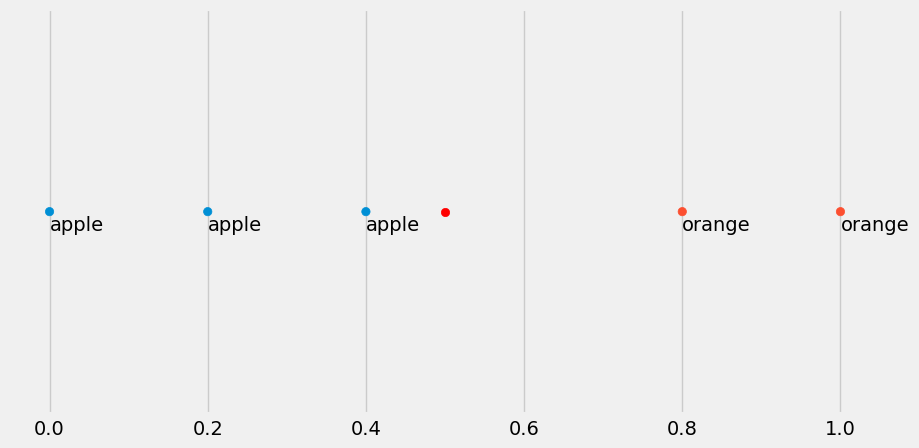

In [10]:
pts = np.array([0.0, 0.2, 0.4, 0.8, 1.0])
classes = np.array(["apple", "apple", "apple", "orange", "orange"])
new_pt = np.array(.5)

plt.scatter(pts, np.array([0]*len(pts)), c=['C0', 'C0', 'C0', 'C1', 'C1'])
for i, (x, s) in enumerate(zip(pts, classes)):
  plt.text(x, -0.005, s)
plt.scatter([new_pt], [0], c='r')
plt.gca().axes.get_yaxis().set_visible(False)

Nous pouvons choisir de modéliser la distribution (inconnue) de chaque classe avec une Gaussienne avec la moyenne et l'écart type calculé empiriquement.

In [15]:
pts_apple = pts[classes=="apple"]
mean_apple, std_apple = np.mean(pts_apple), np.std(pts_apple)

pts_orange = pts[classes=="orange"]
mean_orange, std_orange = np.mean(pts_orange), np.std(pts_orange)

print(f"mean_apple: {mean_apple:.02f} ; std_apple: {std_apple:.02f}")
print(f"mean_orange: {mean_orange:.02f} ; std_orange: {std_orange:.02f}")

mean_apple: 0.20 ; std_apple: 0.16
mean_orange: 0.90 ; std_orange: 0.10


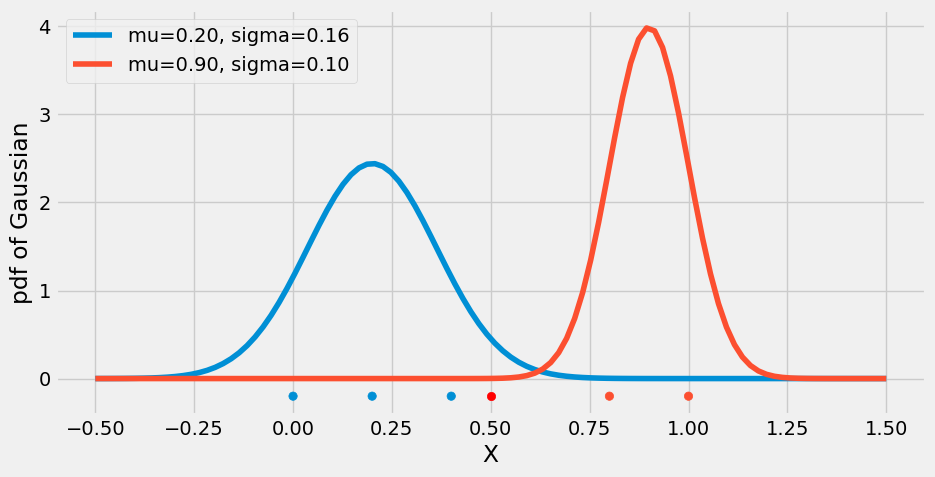

In [12]:
X = np.linspace(-0.5, 1.5, 100)

pdf_apple = [univariate_prob(x, mean_apple, std_apple) for x in X]
my_plot_gaussian(X, pdf_apple, mean_apple, std_apple)

pdf_orange = [univariate_prob(x, mean_orange, std_orange) for x in X]
my_plot_gaussian(X, pdf_orange, mean_orange, std_orange)

plt.scatter(pts, np.array([-0.2]*len(pts)), c=['C0', 'C0', 'C0', 'C1', 'C1'])
# for i, (x, s) in enumerate(zip(pts, classes)):
#   plt.text(x, -0.5, s)
plt.scatter([new_pt], [-0.2], c='r')

Nous pouvons maintenant approximer la probabilité que le point rouge provienne d'une ou l'autre Gaussienne

i.e. $p(\mbox{red}\ |\ \mbox{apple})$ et $p(\mbox{red}\ |\ \mbox{orange})$ et comparer

In [ ]:
p_red_given_apple = univariate_prob(new_pt, mean_apple, std_apple)
p_red_given_orange = univariate_prob(new_pt, mean_orange, std_orange)
print(f"p(red | apple): {p_red_given_apple:.04f}; p(red | orange): {p_red_given_orange:.04f}")

p(red | apple): 0.4519; p(red | orange): 0.0013


L'assignation du point rouge à la class apple ou orange est donné par le numérateur de l'équation Bayesienne.

\begin{align}p(\mbox{apple}\ |\ \mbox{red}) &\approx p(\mbox{red}\ |\ \mbox{apple})\ p(\mbox{apple}) \\
p(\mbox{orange}\ |\ \mbox{red}) &\approx p(\mbox{red}\ |\ \mbox{orange})\ p(\mbox{orange})
\end{align}

où $p(\mbox{apple})$ et $p(\mbox{orange})$ sont les probabilité a priori d'appartenir à l'une ou l'autre des classes.

Disons que les probabilités a priori sont égales (0.5)

In [ ]:
p_apple_given_red = p_red_given_apple * 0.5
p_orange_given_red = p_red_given_orange * 0.5
print(f"p(apple | red): {p_apple_given_red:.04f}; p(orange | red): {p_orange_given_red:.04f}")

p(apple | red): 0.2260; p(orange | red): 0.0007


Vu que $p(\mbox{apple}\ |\ \mbox{red}) > p(\mbox{orange}\ |\ \mbox{red})$, nous pouvons dire que le point rouge est **probablement** une pomme!

## Gaussienne multi-variée

Pour des données à plus hautes dimensions, nous pouvons utiliser une Gaussienne multi-variée

In [16]:
def plot_2D_gaussian(mu, Sigma):
  X1 = np.linspace(-3, 3, 100)
  X2 = np.linspace(-3, 3, 100)
  X1, X2 = np.meshgrid(X1, X2)
  # Pack X and Y into a single 3-dimensional array
  pos = np.empty(X1.shape + (2,))
  pos[:, :, 0] = X1
  pos[:, :, 1] = X2 

  # https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
  def multivariate_gaussian(pos, mu, Sigma):
      """Return the multivariate Gaussian distribution on array pos.
      pos is an array constructed by packing the meshed arrays of variables
      x_1, x_2, x_3, ..., x_k into its _last_ dimension.
      """
      n = mu.shape[0]
      Sigma_det = np.linalg.det(Sigma)
      Sigma_inv = np.linalg.inv(Sigma)
      N = np.sqrt((2*np.pi)**n * Sigma_det)
      # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
      # way across all the input variables.
      fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
      return np.exp(-fac / 2) / N

  # The distribution on the variables X, Y packed into pos.
  pdf = multivariate_gaussian(pos, mu, Sigma)

  from matplotlib import cm
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')
  ax.plot_surface(X1, X2, pdf, rstride=3, cstride=3, linewidth=1, antialiased=True,
                  cmap=cm.viridis)

  cset = ax.contourf(X1, X2, pdf, zdir='z', offset=-0.15, cmap=cm.viridis)
  ax.set_zlim(-0.15,0.2)
  ax.set_zticks(np.linspace(0,0.2,5))
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.view_init(27, -21)

$$
\mu = \begin{pmatrix}
\mu_{1} \\
\mu_{2}  \\
\end{pmatrix},
\sigma = \begin{pmatrix}
\sigma_{1,1} & \sigma_{1,2} \\
\sigma_{2,1} & \sigma_{2,2}  \\
\end{pmatrix}
$$

In [17]:
@interact(
    mu1=FloatSlider(min=-2, max=2, value=0, description='Mean x1', continuous_update=False),
    mu2=FloatSlider(min=-2, max=2, value=0, description='Mean x2', continuous_update=False),
    s11=FloatSlider(min=0.01, max=2, value=1, description='sigma 11', continuous_update=False),
    s12=FloatSlider(min=-2, max=2, value=0, description='sigma 12', continuous_update=False),
    s21=FloatSlider(min=-2, max=2, value=0, description='sigma 21', continuous_update=False),
    s22=FloatSlider(min=0.01, max=2, value=1, description='sigma 22', continuous_update=False),
)
def interactive_2D_gaussian(mu1, mu2, s11, s12, s21, s22):
    Sigma = np.array([[s11 , s12], [s21,  s22]])
    plot_2D_gaussian(np.array([mu1, mu2]), Sigma)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Mean x1', max=2.0, min=-2.0…

Nous allons nous limiter aujourd'hui à un cas particulier de cette distribution, soit la loi **gaussienne isotropique**. Plus précisément, la matrice de covariance $ \Sigma_c $ de chacune de ces distributions est une matrice diagonale dont chacun des éléments sur la diagonale sont égaux (nous notons `sigma_sq` la variance $ \sigma^2 $). Ainsi, nous n'avons qu'un seul paramètre à estimer afin de déterminer la matrice de covariance pour chaque classe. C'est certainement plus facile (pour nous et pour l'ordinateur) de calculer sa valeur, mais ceci veut également dire que notre modèle possède moins de capacité.

## Entraîner les distributions avec les données

Nous avons alors un modèle paramétrique assez simple pour chaque classe $c$. Les paramètres sont l'espérance $ \mu_c $ (un vecteur de la même dimension que nos valeurs d'entrées) et la variance $ \sigma^2_c $ (un scalaire multiplié par la matrice identité). Nous allons apprendre (estimer) ces paramètres à l'aide du maximum de vraisemblance. Pour chaque classe, nous trouverons les valeurs des paramètres qui maximisent la *log-vraisemblance* des points d'entraînement de cette classe:

$$ \log \prod_i^n p(X = x_i) $$

Pour une gaussienne isotropique de dimension $d$, les estimateurs du maximum de vraisemblance $\mu$ et $\sigma^2$ sont:


$$\mu_{ML} = \frac{1}{n} \sum_{i=1}^{n} x_i$$

$$\sigma_{ML}^2 = \frac{1}{nd} \sum_{i=1}^{n} (x_i-\mu_{ML})^T(x_i-\mu_{ML})$$

Après avoir trouvé les paramètres qui maximisent la vraisemblance pour chaque classe, nous pouvons ensuite calculer chaque probabilité $ p (\mbox{exemple} \ |  \ \mbox{classe}) $. Il est maintenant suffisant d'appliquer la règle de Bayes afin de classer un nouvel exemple. Plus précisément, nous voulons trouver, pour un exemple donné, la classe qui maximise $ p(\mbox{exemple} \ | \ \mbox{classe}) p(\mbox{classe}) $ (ou de manière équivalente $ \log (p (\mbox{exemple } \ | \ \mbox{classe} ) p(\mbox{classe})) $. **Au moment test, notre classifieur doit évaluer cette quantité pour chaque classe et utiliser ces valeurs afin d'assigner une classe à l'exemple.**

## Code à compléter

Pour la classe `GaussianMaxLikelihood`:

  - **Calculez** mu ($\mu$) et sigma_sq ($ \sigma^2 $), la moyenne et la variance dans `GaussianMaxLikelihood.train`.
  - **Calculez** la densité de la loi gaussienne dans `GaussianMaxLikelihood.loglikelihood`, definissez la comme étant la variable `log_prob` et **retournez la**.
  
Dans `__init__`, nous initialisons `self.mu` et `self.sigma_sq`. Ces variables seront ensuite modifiées lorsque la fonction `train` sera appelée.


In [39]:
class GaussianMaxLikelihood:
    def __init__(self, n_dims):
        # AJOUTER CODE ICI
        self.n_dims = n_dims
        self.mu = None
        self.sigma_sq = None

    # Pour un jeu d'entraînement, la fonction devrait calculer les estimateur ML de l'espérance et de la variance
    def train(self, train_data):
        # AJOUTER CODE ICI
        self.mu = np.mean(train_data, axis=0)
        n = train_data.shape[0]
        d = self.mu.shape[0]
        self.sigma_sq = np.sum(
            np.einsum("ij,ij->", train_data - self.mu, train_data - self.mu)
        ) / (n * d)

    # Retourne un vecteur de dimension égale au nombre d'ex. test qui contient les log probabilité de chaque
    # exemple test
    def loglikelihood(self, test_data):
        # AJOUTER CODE ICI
        # Ici on prend le log de la fonction de densité d'une gaussienne
        # souvenez-vous des propriétés des log et attention aux erreurs d'instabilité numérique

        def multivariate_gaussian(x, mu_vec, cov_mat):
            """
            Calculates the multivariate Gaussian probability density function (PDF).

            Args:
            - x: The input vector (numpy array) of size (d,).
            - mu_vec: The mean vector (numpy array) of size (d,).
            - sigma_mat: The covariance matrix (numpy array) of size (d, d).

            Returns:
            - The probability density value (float).
            """
            d = self.n_dims
            norm_factor = 1 / ((2 * np.pi) ** (d / 2) * self.sigma_sq**2)
            delta_x_mu = x - mu_vec
            exp_factor = -0.5 * np.dot(
                np.dot(delta_x_mu.T, np.linalg.inv(cov_mat)), delta_x_mu
            )
            return norm_factor * np.exp(exp_factor)

        log_prob = []

        for test_point in test_data:
            log_prob.append(
                np.log(multivariate_gaussian(test_point, self.mu, self.sigma_sq))
            )

        return log_prob

In [40]:
class GaussianMaxLikelihood:
    def __init__(self, n_dims):
        # AJOUTER CODE ICI
        self.n_dims = n_dims
        self.mu = None
        self.sigma_sq = None

    # Pour un jeu d'entraînement, la fonction devrait calculer les estimateur ML de l'espérance et de la variance
    def train(self, train_data):
        # AJOUTER CODE ICI
        self.mu = np.mean(train_data, axis=0)
        n = train_data.shape[0]
        d = self.mu.shape[0]
        self.sigma_sq = np.sum(
            np.einsum("ij,ij->", train_data - self.mu, train_data - self.mu)
        ) / (n * d)

    # Retourne un vecteur de dimension égale au nombre d'ex. test qui contient les log probabilité de chaque
    # exemple test
    def loglikelihood(self, test_data):
        # AJOUTER CODE ICI
        # Ici on prend le log de la fonction de densité d'une gaussienne
        # souvenez-vous des propriétés des log et attention aux erreurs d'instabilité numérique

        log_prob = []

        for test_point in test_data:
            dist_sq = np.sum((test_point - self.mu) ** 2)
            log_likelihood = -0.5 * self.n_dims * np.log(2 * np.pi) - 0.5 * self.n_dims * np.log(self.sigma_sq) - (dist_sq / (2 * self.sigma_sq))
            log_prob.append(log_likelihood)

        return log_prob

Pour la classe `BayesClassifier`:

  - **Complétez** `bayes_classifier.loglikelihood`
  
`self.maximum_likelihood_models` est une liste de longueur égale au nombre de classes. Chaque élément est un modèle qui permet de calculer les log-vraisemblances en utilisant la méthode `loglikelihood`.

`self.priors` est une liste de scalaires. Ils représentent les probabilités à priori des classes.

In [72]:
class BayesClassifier:
    def __init__(self, maximum_likelihood_models, priors):
        # AJOUTER CODE ICI
        self.maximum_likelihood_models = maximum_likelihood_models
        self.priors = priors
        if len(self.maximum_likelihood_models) != len(self.priors):
            print('The number of ML models must be equal to the number of priors!')
        self.n_classes = len(self.priors)

    # Retourne une matrice de dimension [nb d'ex. test, nb de classes] contenant les log
    # probabilités de chaque ex. test sous le modèle entrainé par le MV.
    def loglikelihood(self, test_data):
        # AJOUTER CODE ICI
        log_pred = np.zeros((test_data.shape[0], self.n_classes))
        for i in range(self.n_classes):
            log_likelihood = self.maximum_likelihood_models[i].loglikelihood(test_data)
            log_prior = np.log(self.priors[i])
            log_pred[:, i] = log_likelihood+log_prior
        return log_pred

Dans cette partie, nous allons entraîner BayesClassifier sur le dataset iris, tel qu'expliqué dans la description détaillée. Nous allons utiliser les classes BayesClassifier et GaussianMaxLikelihood.

Contrairement à ce que nous avons fait dans le lab précédent, **nous n'allons pas utiliser un dataset train/test**. Nous allons simplement utiliser le dataset complet pour entraîner le modèle et ensuite **faire des prédictions sur le training set lui-même.**

Des questions bonus se trouvent à la fin de ce notebook pour que vous puissiez explorer avec un ensemble d'entraînement/test. Ces questions ne seront cependant pas testées sur gradescope.

**Complétez** la fonction `get_accuracy(test_inputs, test_labels)`, qui prend en paramètre un ensemble test, et retourne l'exactitude du classifieur (`classifier`) entraîné. Votre fonction devrait retourner un nombre entre 0 et 1.

Pour vous assurer que tout fonctionne, vous pouvez tester votre code par appeller votre fonction sur l'ensemble d'entraînement (cette partie du code, après la fonction, vous est donnée). Souvenez-vous cependant que votre fonction devrait fonctionner avec toutes données d'entrée, et pas seulement (iris_train, iris_labels).

In [80]:
# On télécharge le dataset et le séparons en input et en étiquettes
import sys
import numpy as np

iris = np.loadtxt('http://www.iro.umontreal.ca/~dift3395/files/iris.txt')

iris_train = iris[:, :-1]
iris_labels = iris[:, -1]

# On sépare le input en trois sous-ensembles, correspondant aux classes 1, 2 et 3. Il est nécessaire
# de faire cette partition afin d'entraîner GaussianMaxLikelihood pour chaque classe. Notez que la partition
# (0:50, 50:100 et 100:150) n'est pas arbitraire: elle correspond aux trois classes dans le dataset.
iris_train1 = iris_train[0:50, :]
iris_train2 = iris_train[50:100, :]
iris_train3 = iris_train[100:150, :]

# Nous créons un modèle par classe (en utilisant le maximum de vraisemblance) et les entraînons
model_class1 = GaussianMaxLikelihood(4)
model_class2 = GaussianMaxLikelihood(4)
model_class3 = GaussianMaxLikelihood(4)
model_class1.train(iris_train1)
model_class2.train(iris_train2)
model_class3.train(iris_train3)

# Nous créons une liste de nos modèles et une liste de nos priors. Ici, nos priors sont
# déjà calculés car nous savons les proportions par classe
model_ml = [model_class1, model_class2, model_class3]
priors = [1./3, 1./3, 1./3]


# Nous créons notre classifieur avec notre liste de modèles gaussiens et nos prob à priori
classifier = BayesClassifier(model_ml, priors)

# Retourne un nombre entre 0 et 1 représentant l'exactitude du modèle sur les test_inputs

def get_accuracy(data, labels):
    # Nous pouvons calculez les log-probabilités selon notre modèle
    log_prob = classifier.loglikelihood(data)
    # Il reste à calculer les classes prédites
    classes_pred = log_prob.argmax(1) + 1
    # Retournez l'exactitude en comparant les classes prédites aux vraies étiquettes
    acc = np.mean(classes_pred == labels)
    return acc


if __name__=='__main__':
    print("The training accuracy is : {:.1f} % ".format(100 * get_accuracy(iris_train, iris_labels)))

The training accuracy is : 92.0 % 


## Une fois terminé (Bonus)

- Changez votre code afin que `GaussianMaxLikelihood` calcule 1) une matrice de variance-covariance diagonale (où on estime la variance de chaque élément/trait des données d'entrée) 2) une matrice de variance-covariance complète. Vous pouvez par exemple avoir un paramètre `cov_type` qui peut être `isotropic`, `diagonal` ou `full`. Les commandes `numpy.cov` et `numpy.var` peuvent être utiles.

- À la place d'utiliser le dataset complet iris pour entraîner `BayesClassifier`, performez une séparation aléatoire de (2/3, 1/3) afin d'obtenir un ensemble d'entraînement et un ensemble test. Comparez les exactitudes du classifieur obtenues à partir des ensembles train et test. Prenez soin d'ajuster le code qui définit `iris_train1`, `iris_train2`, `iris_train3` et `priors` en conséquence. Comparez l'exactitude des ensembles train et test des 3 modèles: gaussienne isotropique, gaussienne diagonale et gaussienne *complète*.

- Plutôt que d'utiliser les 4 traits afin d'entraîner votre classifieur, utilisez seulement que deux caractéristiques et effectuer des analyses de visualisation telles que faites dans le lab 2. Vous pouvez biensûr faire usages des fonctions du lab 2 pour faire vos graphiques.

In [ ]:
class GaussianMaxLikelihoodBonus:
    """
    This is a more generic version of the Gaussian with different behaviour for the covariance
    """
    def __init__(self, n_dims, cov_type='isotropic'):
        self.cov_type = cov_type
        self.n_dim       = n_dims
        self.mu = np.zeros(n_dims)
        # Nous avons un scalaire comme écart-type car notre modèle est une loi gaussienne isotropique
        self.sigma_sq = 1.0

    # Pour un jeu d'entraînement, la fonction devrait calculer les estimateur ML de l'espérance et de la variance
    def train(self, train_data):
        # Ici, nous devons trouver la moyenne et la variance dans train_data et les définir dans self.mu and self.

        self.mu = np.mean(train_data, axis=0)

        # AJOUTER CODE ICI
        if self.cov_type == 'isotropic':
            self.covariance = None
        elif self.cov_type == 'diagonal':
            self.covariance = None
        else:
            self.covariance = None


    # Retourne un vecteur de dimension égale au nombre d'ex. test qui contient les log probabilité de chaque
    # exemple test
    def loglikelihood(self, test_data):
        # AJOUTER CODE ICI
        log_prob = None
        return log_prob

In [ ]:
# On télécharge le dataset et le séparons en input et en étiquettes
import sys
import numpy as np

iris = np.loadtxt('http://www.iro.umontreal.ca/~dift3395/files/iris.txt')

iris_train = iris[:, :-1]
iris_labels = iris[:, -1]

# On sépare le input en trois sous-ensembles, correspondant aux classes 1, 2 et 3. Il est nécessaire
# de faire cette partition afin d'entraîner GaussianMaxLikelihood pour chaque classe. Notez que la partition
# (0:50, 50:100 et 100:150) n'est pas arbitraire: elle correspond aux trois classes dans le dataset.
iris_train1 = iris_train[0:50, :]
iris_train2 = iris_train[50:100, :]
iris_train3 = iris_train[100:150, :]

# Nous créons un modèle par classe (en utilisant le maximum de vraisemblance) et les entraînons
cov_type = 'full' # <--- CHANGE THIS
model_class1 = GaussianMaxLikelihoodBonus(4, cov_type)
model_class2 = GaussianMaxLikelihoodBonus(4, cov_type)
model_class3 = GaussianMaxLikelihoodBonus(4, cov_type)
model_class1.train(iris_train1)
model_class2.train(iris_train2)
model_class3.train(iris_train3)

# Nous créons une liste de nos modèles et une liste de nos priors. Ici, nos priors sont
# déjà calculés car nous savons les proportions par classe
model_ml = [model_class1, model_class2, model_class3]
priors = [1./3, 1./3, 1./3]


# Nous créons notre classifieur avec notre liste de modèles gaussiens et nos prob à priori
classifier = BayesClassifier(model_ml, priors)

# Retourne un nombre entre 0 et 1 représentant l'exactitude du modèle sur les test_inputs

def get_accuracy(data, labels):
    # Nous pouvons calculez les log-probabilités selon notre modèle
    log_prob = classifier.loglikelihood(data)
    # Il reste à calculer les classes prédites
    classes_pred = log_prob.argmax(1) + 1
    # Retournez l'exactitude en comparant les classes prédites aux vraies étiquettes
    acc = np.mean(classes_pred == labels)
    return acc


if __name__=='__main__':
    print("The training accuracy is : {:.1f} % ".format(100 * get_accuracy(iris_train, iris_labels)))